# README

We are going to show the frequency that regions of the TI-TE surface are biexponential or monoexponential for a SNR value

I will start with one dimensional lines and eventually change this into a two dimensional surface that shows TI and SNR for a set of parameters

# Libraries

In [14]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import functools

# Options

In [15]:
intEnds = True           #bases TI values around integer values

# Initialization

In [30]:
######All Fixed parameters for code
#Parameters held constant
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

multi_starts_BIC = 3

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Building the TE array - this should be a uniform array
n_TE = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_TE, n_TE) #ms units

#Adjusting the ratio of T21 and T22
# T2rat_array = [2.5]#np.arange(1.5, 2.51, 0.1)

#SNR Values to Evaluate
SNR_array = [100]#10**np.linspace(np.log10(25), np.log10(250), 15)

repetition = 100

## TI index
TI_STANDARD = np.append(0,np.logspace(1,np.log10(3*T12),11))//1

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Adjusting how the window center varies
np1_array = np.floor(TI1star)+TI1star*np.array([-.15, -.125, -0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15])//1
np2_array = np.floor(TI2star)+TI2star*np.array([-.15, -.125, -0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15])//1

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# Functions

In [17]:
#Defining the function of interest

#### Signaling Functions
def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI_val = 0):
    exp1 = c1*(1-2*np.exp(-TI_val/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI_val/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The one dimensional models 
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def calc_R0_coeff(c, T21, T22, T1):
    return (c**2 * T21 *(T21 - T22)**4)/(2*T1**2 * (T21 + T22)**4)

In [18]:
def calc_BIC(RSS, TE_array, p_list, sigma):
    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def calc_BIC_radius(R0, num_TE, diff_TE, SNR):
    return ((2*np.log(num_TE)-2)*diff_TE/(R0*SNR**2))**(1/2)


def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (0, 0, 0, 0, 0, 0)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (0, 0, 0)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 0, 0)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 0)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data


def estP_oneCurve(func, noisey_data, TI_val = 0):

    f_name = func.__name__
    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    if f_name.find("6p") > -1:
        popt, _, info_popt, _, _ = curve_fit(functools.partial(func, TI_val = TI_val), TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
    else:
        popt, _, info_popt, _, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
    popt = check_param_order(popt)
    RSS = np.sum(info_popt['fvec']**2)

    return popt, RSS

def evaluate_model(data, SNR, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = calc_BIC(RSS_biX, TE_DATA, popt_biX, 1/SNR)
    BIC_moX = calc_BIC(RSS_moX, TE_DATA, popt_moX, 1/SNR)

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX

# Generating Data

In [19]:
all_data = np.zeros((TI_STANDARD.shape[0], TE_DATA.shape[0]))

for iTI in range(TI_STANDARD.shape[0]):
    all_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI_val = TI_STANDARD[iTI])

# noised_data = add_noise(all_data, SNR_value)

In [20]:
freq_array = np.zeros(TI_STANDARD.shape[0])

for iTI in trange(TI_STANDARD.shape[0]):
    counter = 0
    for rep in range(repetition):
        noisy_curve = add_noise(all_data[iTI, :], SNR_array[0])
        moX_opt, _, _ = evaluate_model(noisy_curve, SNR_array[0])
        if moX_opt:
            counter += 1
    
    freq_array[iTI] = counter/repetition

100%|██████████| 12/12 [11:24<00:00, 57.06s/it]


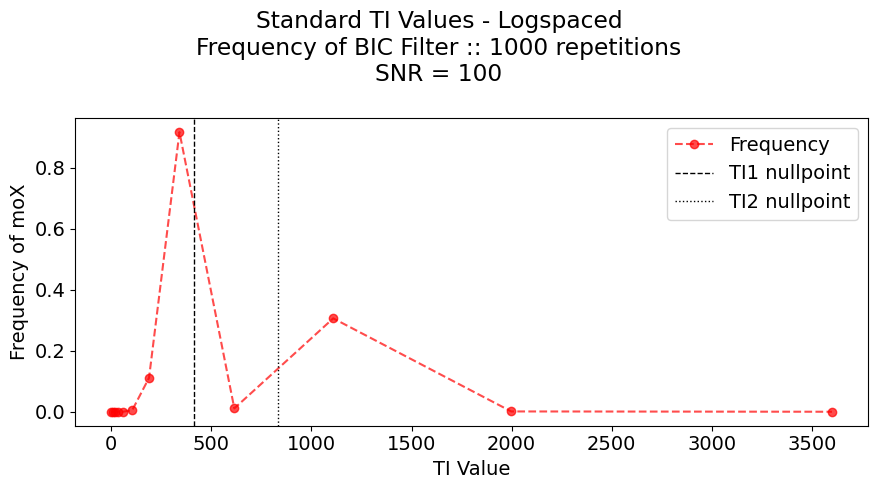

In [22]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Standard TI Values - Logspaced\nFrequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_array[0]}')


ax.plot(TI_STANDARD, freq_array, alpha = 0.7, color = 'r', label = 'Frequency', marker = 'o', ls = '--')

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()

# Null Point Windows

In [32]:
np1_data = np.zeros((np1_array.shape[0], TE_DATA.shape[0]))

for iTI in range(np1_array.shape[0]):
    np1_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI_val = np1_array[iTI])

np2_data = np.zeros((np2_array.shape[0], TE_DATA.shape[0]))

for iTI in range(np2_array.shape[0]):
    np2_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI_val = np2_array[iTI])

In [33]:
np1_freq_array = np.zeros(np1_array.shape[0])

for rep in trange(repetition):
    for iTI in range(len(np1_array)):
        noisy_curve = add_noise(np1_data[iTI, :], SNR_array[0])
        moX_opt, _, _ = evaluate_model(noisy_curve, SNR_array[0])
        if moX_opt:
            np1_freq_array[iTI] += 1
np1_freq_array = np1_freq_array/repetition

100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


In [34]:
np2_freq_array = np.zeros(np2_array.shape[0])

for rep in trange(repetition):
    for iTI in range(len(np2_array)):
        noisy_curve = add_noise(np1_data[iTI, :], SNR_array[0])
        moX_opt, _, _ = evaluate_model(noisy_curve, SNR_array[0])
        if moX_opt:
            np2_freq_array[iTI] += 1
np2_freq_array = np2_freq_array/repetition

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


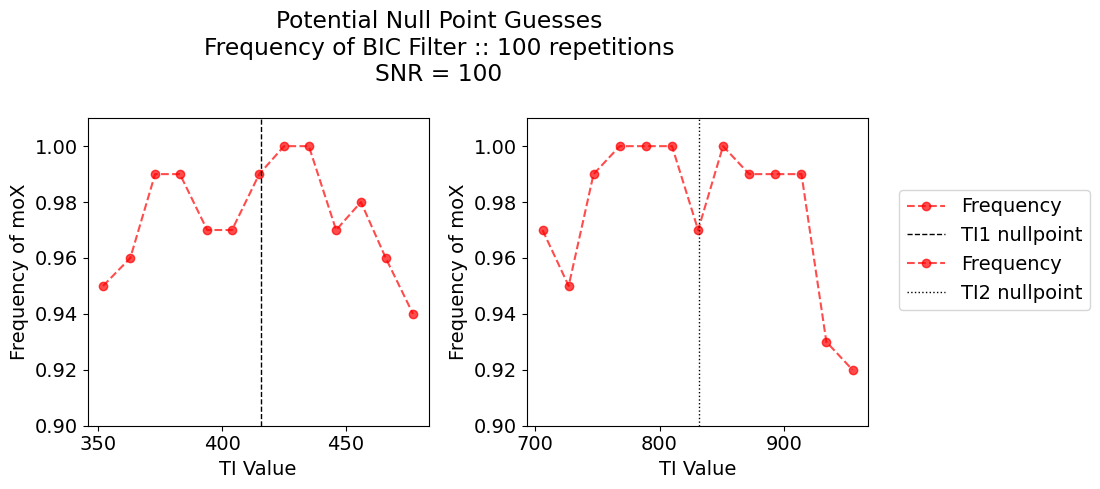

In [43]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(1,2, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Potential Null Point Guesses\nFrequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_array[0]}')

ax[0].plot(np1_array, np1_freq_array, alpha = 0.7, color = 'r', label = 'Frequency', marker = 'o', ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_ylim([0.9,1.01])

ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Frequency of moX')

ax[1].plot(np2_array, np2_freq_array, alpha = 0.7, color = 'r', label = 'Frequency', marker = 'o', ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')
ax[1].set_ylim([0.9,1.01])

ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
# ax.legend()

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [40]:
np1_BIC_boundary_TI = calc_BIC_radius(calc_R0_coeff(c1, T21, T22, T11), n_TE, TE_step, SNR_array[0])
np2_BIC_boundary_TI = calc_BIC_radius(calc_R0_coeff(c2, T21, T22, T12), n_TE, TE_step, SNR_array[0])

print(f"Boundaries of Null Point 1 = [{TI1star - np1_BIC_boundary_TI:0.1f}, {TI1star + np1_BIC_boundary_TI:0.1f}]")

print(f"Boundaries of Null Point 2 = [{TI2star - np2_BIC_boundary_TI:0.1f}, {TI2star + np2_BIC_boundary_TI:0.1f}]")

Boundaries of Null Point 1 = [286.1, 545.7]
Boundaries of Null Point 2 = [658.7, 1004.9]
